In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import models, transforms

import cv2
import json
import glob
import random
import numpy as np
import pandas as pd
import os.path as osp
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import normalize


%matplotlib inline

In [7]:
def make_datapath_list(rootpath):
    train_path = osp.join(rootpath + "/train_images/")
    train_csv_path = osp.join(rootpath + "/train_images.csv")
    
    train_img_list = list()
    train_label_list = list()
    for line in open(train_csv_path):
        if line.strip() == "id,class_num":
            continue
        file_id = line.strip()[:14]
        label_id = int(line.strip()[15])
        
        train_img_list.append(train_path + file_id)
        train_label_list.append(label_id)
    
    return train_img_list, train_label_list

In [8]:
def make_testdatapath_list(rootpath):
    test_path = osp.join(rootpath + "/test_images/")
    test_csv_path = osp.join(rootpath + "/test_images.csv")
    
    test_img_list = list()
    for line in open(test_csv_path):
        if line.strip() == "id":
            continue
        file_id = line.strip()[:14]
        test_img_list.append(test_path + file_id)
        
    return test_img_list

In [9]:
rootpath  = "."
train_img_list, train_label_list = make_datapath_list(rootpath)
test_img_list = make_testdatapath_list(rootpath)

# 動作確認
print(train_img_list[0])
print(train_label_list[0])
print(test_img_list[0])

./train_images/train_0000.jpg
0
./test_images/test_0000.jpg


In [10]:
def show_img(img_path):
    """
    画像のファイルパスから画像を出力する関数
    """
    img = cv2.imread(img_path)
    
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show();

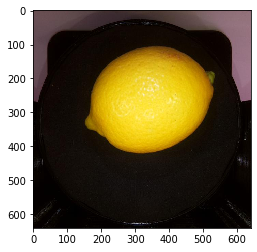

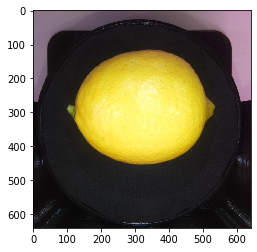

In [11]:
show_img(train_img_list[0])
show_img(test_img_list[0])

In [26]:
def test(train_img_list, validation_size):
    length = len(train_img_list)
    val_length = int(length * validation_size)
    
    val_img_list = random.sample(train_img_list, val_length)
    train_img_list = [i for i in train_img_list if i not in val_img_list]
    return train_img_list, val_img_list

In [27]:
print("pretrain_size: {}".format(len(train_img_list)))
train, val = test(train_img_list, 0.3)
print("train: {}, val: {}".format(len(train), len(val)))

pretrain_size: 1102
train: 772, val: 330


In [41]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    train_img_list, train_label_list, test_size=0.2, random_state=0)

In [44]:
len(X_train), len(y_train), len(X_val), len(y_val)

(881, 881, 221, 221)

In [3]:
def train_val_split(train_img_list, label, validation_size=0.3):
    # データ長
    length = len(train_img_list)
    # 検証用データ長
    val_length = length*validation_size
    # データ分割
    val_img_list = random.sample(train_img_list, val_length)
    train_img_list = [i for i in train_img_list if i not in val_img_list]
    return train_img_list, val_img_list

In [53]:
class LemonDataset(data.Dataset):
    
    def __init__(self, img_path, transform=None, train=True):
        self.transform = transform
        self.img_path = img_path
        self.labels = []
        self.train = train
        
        df = pd.read_csv("./train_images.csv")
        for label in df["class_num"]:
            self.labels.append(label)
            
    def __len__(self):
        return len(self.img_path)
    
    def __getitem__(self, index):
        img = self.img_path[index]
        label = self.labels[index]
        
        with open(img, "rb") as f:
            img = Image.open(f)
            img = img.convert("RGB")
        
        if self.transform is not None:
            img = self.transform(img)
        
        if self.train:
            pass
        
        return img, label

In [55]:
class LemonDataset(data.Dataset):
    
    def __init__(self, img_list, label_list, transform=None):
        self.transform = transform
        self.img_list = img_list
        self.label_list = label_list
            
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, index):
        img = self.img_list[index]
        label = self.label_list[index]
        
        with open(img, "rb") as f:
            img = Image.open(f)
            img = img.convert("RGB")
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img, label

In [56]:
transform = transforms.Compose(
        [transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [59]:
batch_size = 32
trainset = LemonDataset(X_train, y_train, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

valset = LemonDataset(X_val, y_val, transform=transform)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=True)
dataloaders_dict = {"train": trainloader, "val": valloader}

In [60]:
batch_iterator = iter(trainloader)
img, label = next(batch_iterator)
print(img.size())
print(label)

torch.Size([32, 3, 640, 640])
tensor([0, 3, 3, 2, 0, 3, 2, 0, 2, 1, 3, 1, 0, 0, 0, 1, 1, 1, 0, 0, 2, 3, 2, 0,
        3, 1, 2, 0, 0, 0, 0, 1])


In [61]:
use_pretrained = True
net = models.vgg16(pretrained = use_pretrained)
net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [62]:
net.classifier[6] = nn.Linear(in_features=4096, out_features=4)

In [63]:
net.train()
print("Completed")

Completed


In [64]:
criterion = nn.CrossEntropyLoss()

In [66]:
# fine tuning

params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

update_params_names_1 = ["features"]
update_params_names_2 = ["classifier.0.weight", "classifier.0.bias", 
                                                   "classifier.3.weight", "classifier.3.bias"]
update_params_names_3 = ["classifier.6.weight", "classidier.6.bias"]

for name, param in net.named_parameters():
    if update_params_names_1[0] in name:
        param.requires_grad = True
        params_to_update_1.append(param)
        print("params_to_update_1: ", name)
    elif name in update_params_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2: ", name)
    elif name in update_params_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)
        print("params_to_update_3: ", name)
    else:
        param.requires_grad = False
        print("non gradient")

params_to_update_1:  features.0.weight
params_to_update_1:  features.0.bias
params_to_update_1:  features.2.weight
params_to_update_1:  features.2.bias
params_to_update_1:  features.5.weight
params_to_update_1:  features.5.bias
params_to_update_1:  features.7.weight
params_to_update_1:  features.7.bias
params_to_update_1:  features.10.weight
params_to_update_1:  features.10.bias
params_to_update_1:  features.12.weight
params_to_update_1:  features.12.bias
params_to_update_1:  features.14.weight
params_to_update_1:  features.14.bias
params_to_update_1:  features.17.weight
params_to_update_1:  features.17.bias
params_to_update_1:  features.19.weight
params_to_update_1:  features.19.bias
params_to_update_1:  features.21.weight
params_to_update_1:  features.21.bias
params_to_update_1:  features.24.weight
params_to_update_1:  features.24.bias
params_to_update_1:  features.26.weight
params_to_update_1:  features.26.bias
params_to_update_1:  features.28.weight
params_to_update_1:  features.28

In [68]:
optimizer = optim.SGD([
    {"params": params_to_update_1, "lr": 1e-4},
    {"params": params_to_update_2, "lr": 5e-4},
    {"params": params_to_update_3, "lr": 1e-3},
    ], momentum=0.9)

In [69]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Using Device: ", device)
    
    net.to(device)
    
    torch.backends.cudnn.benchmark = True
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        print("--------------------")
        
        for phase in ["train", "val"]:
            if phase == "train":
                net.train()
            else:
                pass
            
            epoch_loss = 0.0
            epoch_corrects = 0
            
            if (epoch == 0) and (phase == "train"):
                continue
                
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == "train"):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

In [70]:
num_epochs = 2
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

  0%|          | 0/7 [00:00<?, ?it/s]

Using Device:  cpu
Epoch 1/2
--------------------


  0%|          | 0/7 [00:31<?, ?it/s]


KeyboardInterrupt: 